In [1]:
import gzip
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc

In [2]:
cache_dir = 'caches/cache_11_14_big'
with gzip.GzipFile(os.path.join(cache_dir, 
        'extended_stroke_library_intensities.npy'),'r') as f:
    strokes = np.load(f).astype(np.float32)/255.
trajectories = np.load(os.path.join(cache_dir, 
        'extended_stroke_library_trajectories.npy'), 
        allow_pickle=True, encoding='bytes') 

strokes = torch.from_numpy(strokes).float().nan_to_num()
trajectories = torch.from_numpy(trajectories.astype(np.float32)).float().nan_to_num()

n = len(strokes)

# scale_factor = opt.max_height / strokes.shape[1]
stroke_shape = np.load(os.path.join(cache_dir, 'stroke_size.npy'))
h, w = stroke_shape[0], stroke_shape[1]
# strokes = transforms.Resize((int(strokes.shape[1]*scale_factor), int(strokes.shape[2]*scale_factor)))(strokes)
strokes = transforms.Resize((h,w))(strokes)

hs, he = int(.4*h), int(0.6*h)
ws, we = int(0.45*w), int(0.75*w)
strokes = strokes[:, hs:he, ws:we]

C:\Users\Ldori\miniconda3\envs\frida\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [3]:
from torch import nn
from torch.nn import functional as F
class StrokeVAE(nn.Module): # inspired by https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
    def __init__(self):
        super(StrokeVAE, self).__init__()
        
        hidden_dims = [8, 16, 32, 64, 128]
        self.latent_dim = 5
        
        # Encoder
        encoder_layers = []
        prev_d = 1
        for d in hidden_dims:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=prev_d,
                          out_channels=d,
                          kernel_size=3,
                          stride=2,
                          padding=1),
                nn.BatchNorm2d(d),
                nn.LeakyReLU()
            )
            encoder_layers.append(conv_block)
            prev_d = d
        self.encoder = nn.Sequential(*encoder_layers)
        self.mean_fc = nn.Linear(2*2*hidden_dims[-1], self.latent_dim)
        self.var_fc = nn.Linear(2*2*hidden_dims[-1], self.latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(self.latent_dim, 2*2*hidden_dims[-1])
        decoder_layers = []
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            deconv_block = nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[i],
                                   hidden_dims[i + 1],
                                   kernel_size=3,
                                   stride=2,
                                   padding=1,
                                   output_padding=1),
                nn.BatchNorm2d(hidden_dims[i + 1]),
                nn.LeakyReLU()
            )
            decoder_layers.append(deconv_block)
        self.decoder = nn.Sequential(*decoder_layers)
        self.decoder_final = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1,
                      kernel_size=3, padding=1),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mean = self.mean_fc(x)
        logvar = self.var_fc(x)
        return mean, logvar
    
    def decode(self, x):
        x = self.decoder_fc(x)
        x = x.view(-1, 128, 2, 2)
        x = self.decoder(x)
        x = self.decoder_final(x)
        return x
    
    def sample(self, mean, logvar):
        var = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mean)
        return mean + eps*var
    
    def forward(self, x):
        # Returns [decoder output, encoder input, log(variance), mean]
        mean, logvar = self.encode(x)
        latent = self.sample(mean, logvar)
        dec = self.decode(latent)
        return [dec, x, logvar, latent]
    
    def loss(self, args):
        decoder_output = args[0]
        encoder_input = args[1]
        logvar = args[2]
        mean = args[3]
        
        reconstruction_loss = F.mse_loss(decoder_output, encoder_input)
        regularization_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean**2 - logvar.exp(), dim=1), dim=0)
        
        return reconstruction_loss + 0.0003*regularization_loss
    
    def sample_latent(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        samples = self.decode(z)
        return samples

In [5]:
from torch.utils.data import Dataset

class StrokeDataset(Dataset):
    def __init__(self, strokes):
        # strokes: N x 64 x 64
        self.strokes = strokes.unsqueeze(1)
    
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx]

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

resize = torchvision.transforms.Resize((64, 64))
s = resize(strokes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = StrokeVAE()
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(s))
train = s[:train_test_split]
test = s[train_test_split:]

train_dataset = StrokeDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeDataset(test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for xs in dataloader:
        batch_size = len(xs)
        args = model(xs)
        loss = model.loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            decoder_outputs.append(args[0][i].squeeze(0).detach().numpy())
            originals.append(args[1][i].squeeze(0).detach().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

for epoch in range(100):
    total_loss = 0
    for (i, xs) in enumerate(train_dataloader):
        batch_size = len(xs)
        args = model(xs)
        loss = model.loss(args)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                decoded = args[0][i].squeeze(0).detach().numpy()
                original = args[1][i].squeeze(0).detach().numpy()
                plt.imsave(f"{output_dir}/{i}-decoded.png", decoded)
                plt.imsave(f"{output_dir}/{i}-original.png", original)
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)
    output_dir = f"training_outputs/epoch{epoch}/val"
    os.makedirs(output_dir, exist_ok=True)
    for i in range(len(decoded_list)):
        decoded = decoded_list[i]
        original = original_list[i]
        plt.imsave(f"{output_dir}/{i}-decoded.png", decoded)
        plt.imsave(f"{output_dir}/{i}-original.png", original)
    #print(f"Train loss={train_loss}, Validation loss={val_loss}")

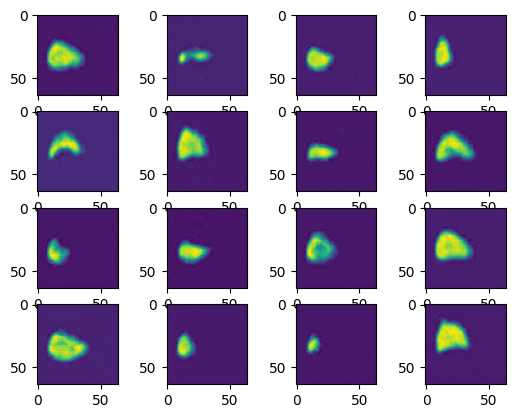

In [7]:
example_strokes = model.sample_latent(16)
_, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        idx = 4*i + j
        axs[i][j].imshow(example_strokes[idx].squeeze(0).detach().numpy())